# Creating an Autoencoder 

## Setting up dependencies + loading the data from csv files 

In [116]:
# Imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import joblib
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

file_path = '../data/raw/KDDTrain+.csv'

# Load the CSV file
data = pd.read_csv(file_path)

file_path = '../data/raw/KDDTest+.csv'

data_test = pd.read_csv(file_path)

# Convert to a pandas DataFrame
df = pd.DataFrame(data)
df.columns = df.columns.str.strip("'")

df_test = pd.DataFrame(data_test)
df_test.columns = df_test.columns.str.strip("'")

#Let's use the features most correlated with determining the class from the dataset 

selected_features = ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'class']
selected_features_more = ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_diff_srv_rate', 'class']
df_selected = df[selected_features_more]
df_test_selected = df_test[selected_features_more]


#print(df.head())

## Including a feature scaler, so that the numerical feature scale isn't a problem

In [128]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = df.select_dtypes(include=['float64', 'int64'])
numerical_features_test = df_test.select_dtypes(include=['float64', 'int64'])
#df[numerical_features.columns] = scaler.fit_transform(numerical_features)

# for col in df.columns:
#     print(col)

# for col in df_test.columns:
#     print(col)


Also converting categorical variables with one-hot encoding

In [127]:
# df.drop('src_bytes', axis=1, inplace=True)
df = pd.get_dummies(df_selected)
df_test = pd.get_dummies(df_test_selected)

# df = pd.get_dummies(df)
# df_test = pd.get_dummies(df_test)


# Align the columns of the test dataset to match the training dataset
df_test = pd.get_dummies(df_test)

# Get missing columns in the test set
missing_cols = set(df.columns) - set(df_test.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
df_test = df_test[df.columns]

Now some more data processing. Here I: 

- create two dataframes, one containing the normal connections, and one for the anomalies 
- Perform the data splitting for training(80%), testing(10%) and validation(10%) 
- 

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'class_normal' and 'class_anomaly' are binary columns indicating the class
normal_data = df[df["class_normal"] == 1]
anomalies = df[df['class_anomaly'] == 1]

normal_data_test = df_test[df_test["class_normal"] == 1]
anomalies_test = df_test[df_test['class_anomaly'] == 1]

# Split the normal data
X_train, X_temp = train_test_split(normal_data, test_size=0.2, random_state=42)
X_val, X_test_normal = train_test_split(X_temp, test_size=0.5, random_state=42)

# Remove 'class_normal' and 'class_anomaly' columns
X_train = X_train.drop(['class_normal', 'class_anomaly'], axis=1)
X_val = X_val.drop(['class_normal', 'class_anomaly'], axis=1)
X_test_normal = X_test_normal.drop(['class_normal', 'class_anomaly'], axis=1)
X_test_full = df_test.drop(['class_normal', 'class_anomaly'], axis=1)
y_test_full = df_test[['class_normal', 'class_anomaly']].values

y_test_full = y_test_full.astype(int)
y_test_full = y_test_full[:,1]

# Fit and transform scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_full_scaled = scaler.transform(X_test_full)

# Transform validation and normal test data
X_val_scaled = scaler.transform(X_val)
X_test_normal_scaled = scaler.transform(X_test_normal)

# Prepare anomaly test data
X_test_anomaly = anomalies.sample(n=len(X_test_normal))
X_test_anomaly_scaled = scaler.transform(X_test_anomaly.drop(['class_normal', 'class_anomaly'], axis=1))

# Combine scaled normal and anomaly samples to create the final test set
X_test_scaled = np.concatenate([X_test_normal_scaled, X_test_anomaly_scaled])

# Prepare true labels for the test set
y_true_normal = np.zeros(len(X_test_normal))
y_true_anomaly = np.ones(len(X_test_anomaly))
y_true = np.concatenate([y_true_normal, y_true_anomaly])


In [99]:

from scipy.stats import ks_2samp
import numpy as np

# Initialize lists to store the results
p_values = []
ks_statistics = []

# Determine the number of features (assuming X_train_scaled and X_val_scaled are NumPy arrays)
num_features = X_train_scaled.shape[1]

# Loop over each feature
for i in range(num_features):
    # Perform the KS test for this feature
    stat, p = ks_2samp(X_train_scaled[:, i], X_val_scaled[:, i])
    
    # Append the results to our lists
    ks_statistics.append(stat)
    p_values.append(p)

# Optionally, you can adjust the significance level
alpha = 0.05

# Check how many features have different distributions
different_distribution_count = sum(p < alpha for p in p_values)

print(f"Features with distribution differences: {different_distribution_count} out of {num_features}")

# If you want to see the results for each feature
for i in range(num_features):
    print(f"Feature {i}: KS Statistic={ks_statistics[i]}, P-Value={p_values[i]}")


Features with distribution differences: 0 out of 14
Feature 0: KS Statistic=0.006767443453043198, P-Value=0.9450731593592951
Feature 1: KS Statistic=0.007576633370151575, P-Value=0.8793418787745163
Feature 2: KS Statistic=0.0035999033660243374, P-Value=0.9999985945308653
Feature 3: KS Statistic=0.0034886371338092026, P-Value=0.9999994704726434
Feature 4: KS Statistic=0.0016332811187472068, P-Value=1.0
Feature 5: KS Statistic=0.006669755416831902, P-Value=0.9511227327493561
Feature 6: KS Statistic=0.010346552277725019, P-Value=0.5398389448132135
Feature 7: KS Statistic=0.0019493724806119994, P-Value=1.0
Feature 8: KS Statistic=0.0012992508816097592, P-Value=1.0
Feature 9: KS Statistic=0.002170047108236206, P-Value=1.0
Feature 10: KS Statistic=0.0023001894034303527, P-Value=0.9999999999999996
Feature 11: KS Statistic=0.002635305675733335, P-Value=0.9999999999971273
Feature 12: KS Statistic=0.00887226780978867, P-Value=0.7301520467759319
Feature 13: KS Statistic=0.009475088993966319, P-Va

In [119]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam

X_train = np.asarray(X_train).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
X_train_scaled = np.asarray(X_train_scaled).astype(np.float32)
X_val_scaled = np.asarray(X_val_scaled).astype(np.float32)
X_test_scaled = np.asarray(X_test_scaled).astype(np.float32)

X_test_full_scaled = np.asarray(X_test_full_scaled).astype(np.float32)
X_test_full = np.asarray(X_test_full).astype(np.float32)
y_test_full = np.asarray(y_test_full).astype(np.float32)


input_dim = X_train_scaled.shape[1]
encoding_dim = 6  # or choose a different size for the encoding layer

# Encoder
input_layer = Input(shape=(input_dim,))
# encoder = Dense(1024, activation="relu", activity_regularizer=l2(1e-5))(input_layer)
# encoder = Dropout(0.5)(encoder)
# encoder = Dense(512, activation="relu", activity_regularizer=l2(1e-5))(encoder)
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="relu")(encoder)  # Bottleneck layer

#, activity_regularizer=l1(1e-5)

# Decoder
decoder = Dense(32, activation="relu")(encoder)
decoder = Dense(64, activation="relu")(decoder)
# decoder = Dense(512, activation="relu", activity_regularizer=l2(1e-5))(decoder)
# decoder = Dense(1024, activation="relu", activity_regularizer=l2(1e-5))(decoder)
# decoder = Dropout(0.5)(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)


autoencoder = Model(inputs=input_layer, outputs=decoder)

# Specify a learning rate
learning_rate = 0.01

# Create and compile the model with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)


autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val_scaled, X_val_scaled))


Epoch 1/20
211/211 [==============================] - 3s 5ms/step - loss: 0.6197 - val_loss: 1.1723
Epoch 2/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 3/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 4/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 5/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 6/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 7/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 8/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 9/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723
Epoch 10/20
211/211 [==============================] - 1s 4ms/step - loss: 0.6148 - val_loss: 1.1723

In [120]:
use_test = False 

if use_test: 
    y_labels = y_test_full 
    X_testset = X_test_full_scaled
else: 
    y_labels = y_true
    X_testset = X_test_scaled


# Predict using the autoencoder
X_test_pred = autoencoder.predict(X_testset)
reconstruction_error = np.mean(np.power(X_testset - X_test_pred, 2), axis=1)


# Define a threshold and predict anomalies
threshold = 0.95
y_pred = [1 if e > threshold else 0 for e in reconstruction_error]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#Calculate accuracy
accuracy = accuracy_score(y_labels, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score
precision = precision_score(y_labels, y_pred)
recall = recall_score(y_labels, y_pred)
f1 = f1_score(y_labels, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Optionally, print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_labels, y_pred))


421/421 [==============================] - 1s 2ms/step
Accuracy: 0.9026726057906459
Precision: 0.8685784180483828
Recall: 0.9489235337787676
F1 Score: 0.9069750940183069
Confusion Matrix:
[[5768  967]
 [ 344 6391]]


<Figure size 1200x800 with 0 Axes>

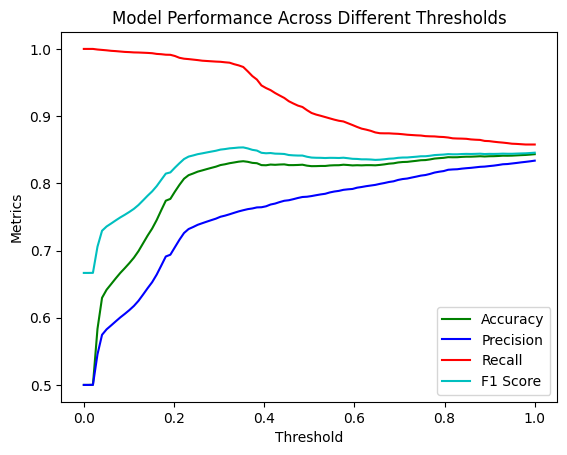

In [112]:
# Define a range of thresholds
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
false_negatives = []
false_positives = []

for threshold in thresholds:
    y_pred = [1 if e > threshold else 0 for e in reconstruction_error]
    
    accuracies.append(accuracy_score(y_labels, y_pred))
    precisions.append(precision_score(y_labels, y_pred))
    recalls.append(recall_score(y_labels, y_pred))
    f1_scores.append(f1_score(y_labels, y_pred))
    
    # Calculate confusion matrix and extract false negatives (FN)
    tn, fp, fn, tp = confusion_matrix(y_labels, y_pred).ravel()
    false_negatives.append(fn)
    false_positives.append(fp)

plt.figure(figsize=(12, 8))

# Create a plot with a primary and secondary y-axis
fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Plotting the metrics on the primary y-axis
accuracy_line, = ax1.plot(thresholds, accuracies, label='Accuracy', color='g')
precision_line, = ax1.plot(thresholds, precisions, label='Precision', color='b')
recall_line, = ax1.plot(thresholds, recalls, label='Recall', color='r')
f1_score_line, = ax1.plot(thresholds, f1_scores, label='F1 Score', color='c')

# Plot False Negatives on the secondary y-axis
#false_negatives_line, = ax2.plot(thresholds, false_negatives, label='False Negatives', color='y')
#false_positives_line, = ax2.plot(thresholds, false_positives, label='False Positives', color='m')

# Labels and titles
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Metrics')
#ax2.set_ylabel('False Negatives', color='y')
#ax2.set_ylabel('False Positives', color='m')

# Collecting handles and labels for both axes
handles = [accuracy_line, precision_line, recall_line, f1_score_line]
labels = [h.get_label() for h in handles]

# Creating a single legend for both lines
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.11))

plt.title('Model Performance Across Different Thresholds')
plt.show()


AUC: 0.947972733821316


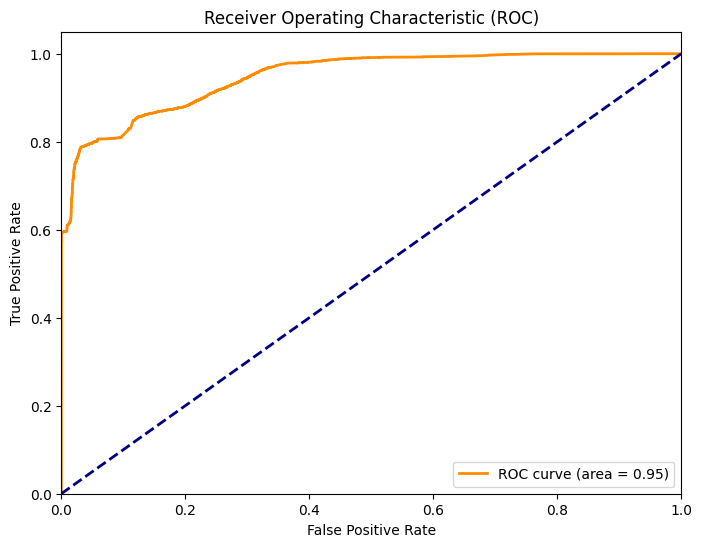

In [85]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming y_true contains the actual labels for the test set (0 for normal, 1 for anomalies)
# and reconstruction_error contains the reconstruction error from the autoencoder

# The threshold does not directly apply here; instead, use reconstruction error directly
fpr, tpr, thresholds = roc_curve(y_labels, reconstruction_error)
roc_auc = auc(fpr, tpr) 

print(f"AUC: {roc_auc}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


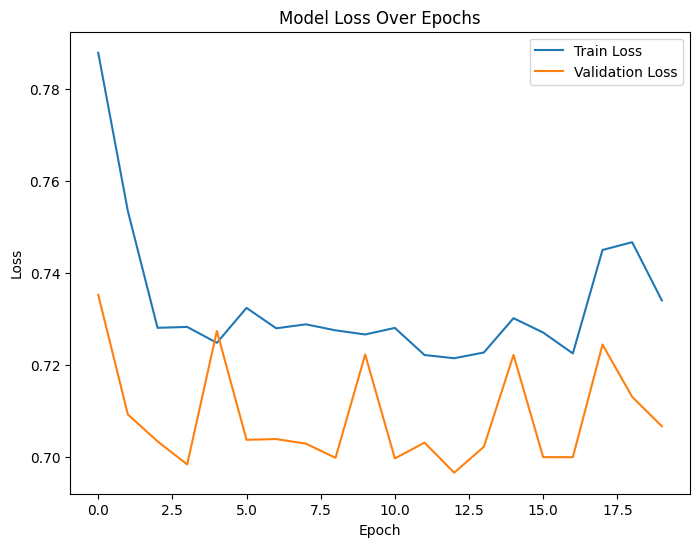

In [105]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


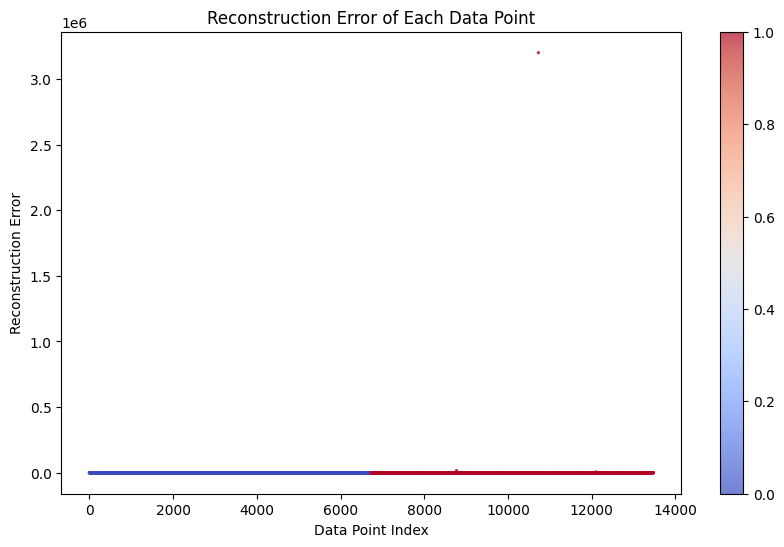

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=y_labels, cmap='coolwarm', label=['Normal', 'Anomaly'], alpha=0.7, s=2)
plt.colorbar()
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Each Data Point')
plt.show()



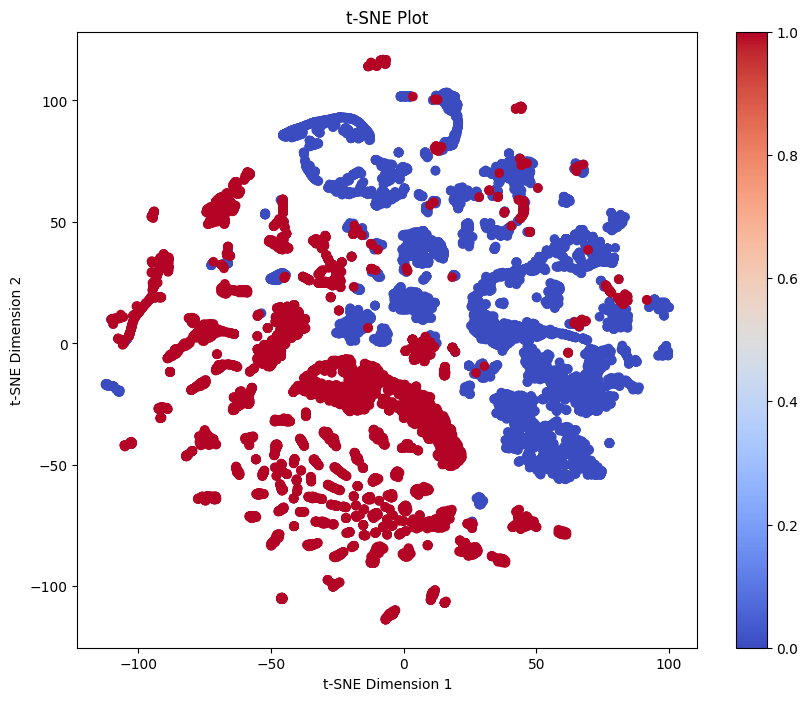

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you have a dataset X (feature matrix) and labels y
# X should be a 2D array where each row represents a data point, and y is the corresponding labels.

# Initialize the t-SNE model with desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Fit the t-SNE model to your data
X_tsne = tsne.fit_transform(X_test_scaled)

# Create a scatter plot of the t-SNE results, color-coded by labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_labels, cmap='coolwarm')
plt.colorbar(scatter)

# Optionally, you can add labels or other plot customizations
plt.title("t-SNE Plot")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Show the plot
plt.show()


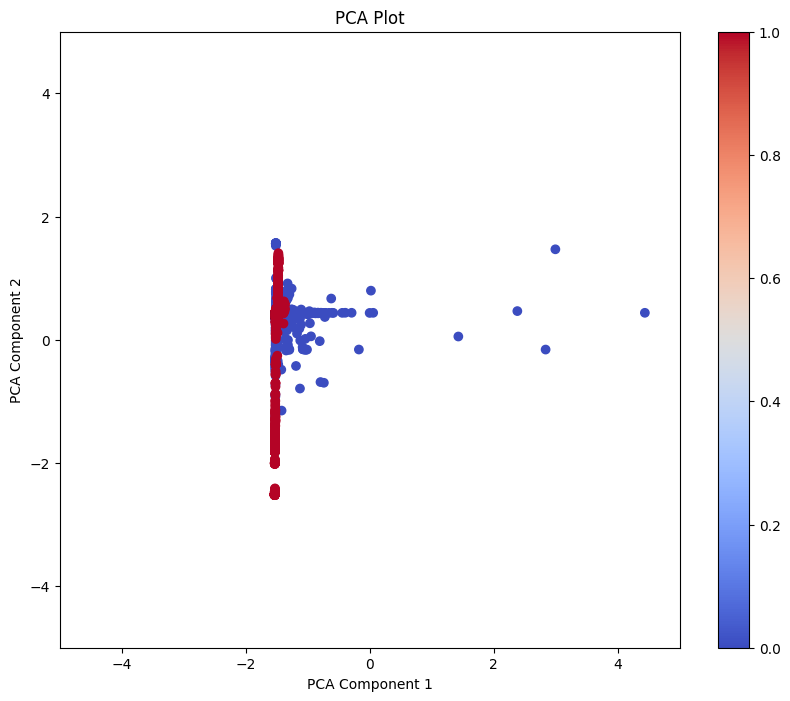

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have a dataset X (feature matrix) and labels y
# X should be a 2D array where each row represents a data point, and y is the corresponding labels.

# Initialize the PCA model with the desired number of components (e.g., 2 or 3)
pca = PCA(n_components=2)

# Fit and transform the PCA model to your data
X_pca = pca.fit_transform(X_test_scaled)

# Create a scatter plot of the PCA results, color-coded by labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_labels, cmap='coolwarm')
plt.colorbar(scatter)

# Optionally, you can add labels or other plot customizations
plt.title("PCA Plot")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# # Set the maximum range for both x and y axes to 2500
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

# Show the plot
plt.show()
